Aqui, me baseei nos links:<br>
https://stackoverflow.com/questions/36360469/read-nc-netcdf-files-using-python<br>
https://www.youtube.com/watch?v=K1_8EqCJlwo

In [200]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate 
from scipy import optimize

# Read data

In [201]:
%run profile_read_py.py

In [202]:
arquivo = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/RM1183023.324'

read = profile_read(arquivo)
phy  = read[1]

df = pd.DataFrame(phy)

# Aqui é um jeito provisório de fazer o header

lista = []
for i in range(len(read[0]['ch']['active'])):
    wlen = str(read[0]['ch']['wlen'][i])
    pol = str(read[0]['ch']['pol'][i])
    photon = read[0]['ch']['photons'][i]
    an = 'analog' if photon == 0 else 'photon'
    tr = read[0]['ch']['tr'][i]
    lista.append(wlen + ' ' + pol + ' ' + an + ' ' + tr[-1])

###############################################


df.columns = lista
alt = 7.5*(np.array(df.index) + 1)

df['alt'] = alt
s355 = df['355 o analog 0']

In [203]:
alt

array([7.50000e+00, 1.50000e+01, 2.25000e+01, ..., 2.99850e+04,
       2.99925e+04, 3.00000e+04])

In [204]:
df

,355 o analog 0,355 o photon 0,387 o analog 1,387 o photon 1,408 o photon 2,alt
0,1.610514,135.066667,2.006006,78.700000,2.833333,7.5
1,1.610107,132.966667,2.006917,66.466667,2.233333,15.0
2,1.607259,131.233333,2.006453,62.566667,1.433333,22.5
3,1.609294,130.533333,2.006340,62.700000,1.566667,30.0
4,1.608073,125.733333,2.005892,55.833333,1.233333,37.5
...,...,...,...,...,...,...
3995,1.615804,0.000000,2.010620,0.000000,0.000000,29970.0
3996,1.618856,0.000000,2.010539,0.033333,0.000000,29977.5
3997,1.614583,0.000000,2.009847,0.000000,0.000000,29985.0
3998,1.613770,0.000000,2.010352,0.000000,0.000000,29992.5


# IMPORTANT

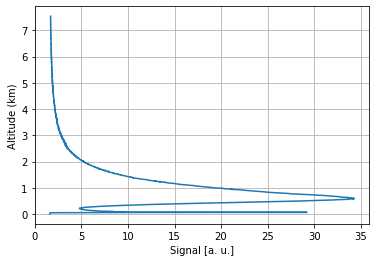

In [205]:
limit_alt = 7537.5e-3  #km
limit_index = int(limit_alt*1e3/7.5)

s355l = s355[:limit_index]
altl = alt[:limit_index]



plt.plot(s355l, (altl*1e-3))
plt.grid(True)
plt.ylabel('Altitude (km)')
plt.xlabel('Signal [a. u.]')
plt.savefig('fig1', dpi=200)

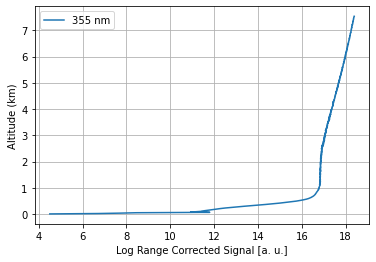

In [206]:
plt.plot(np.log(s355l*altl*altl), altl*1e-3)
plt.grid(True)
plt.legend(['355 nm'])
plt.ylabel('Altitude (km)')
plt.xlabel('Log Range Corrected Signal [a. u.]')
plt.savefig('fig3', dpi=200)

# Read Temperature and Pressure data

Estava tendo problemas de leitura do txt, então decidi apagar as primeiras linhas de índices e adicioná-los manualmente. Um outro problema foi que existem mais índices do que colunas (lidar ratio e depolarization ratio), então a quinta coluna ainda ficou em dúvida.

In [207]:
meteo = pd.read_csv('/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/Ex1/Solut355.txt', sep='\t', header=None)

meteo = meteo.rename(columns={0: 'Pressure',
                             1: 'temperature',
                             2: 'dewpoint',
                             3: 'PEC (1/m)',
                             4: 'lidar ratio (sr)',
                             5: 'altitude (m)'})

meteo = meteo[['Pressure', 'temperature', 'dewpoint', 'PEC (1/m)', 'lidar ratio (sr)', 'altitude (m)']]

pres = meteo['Pressure'] * 100
meteo_alt = meteo['altitude (m)']
temp = meteo['temperature'] + 273.15

meteo.to_csv('Testando2', index=False) ##########

meteo

,Pressure,temperature,dewpoint,PEC (1/m),lidar ratio (sr),altitude (m)
0,1013.00,0.00,-9.13,28,0,7.5
1,1011.10,-0.10,-9.27,28,0,22.5
2,1009.20,-0.20,-9.36,28,0,37.5
3,1007.31,-0.29,-9.45,28,0,52.5
4,1005.42,-0.39,-9.54,28,0,67.5
...,...,...,...,...,...,...
1000,102.35,-77.90,-99.71,28,0,15007.5
1001,102.08,-77.90,-99.71,28,0,15022.5
1002,101.82,-77.90,-99.71,28,0,15037.5
1003,101.55,-77.90,-99.71,28,0,15052.5


In [208]:
TESTE = meteo['Pressure'].values
TESTE

array([1013.  , 1011.1 , 1009.2 , ...,  101.82,  101.55,  101.28])

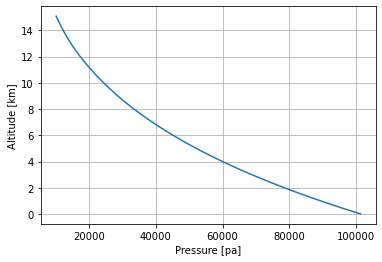

In [209]:
plt.plot(pres, meteo_alt*1e-3)
plt.grid(True)
plt.xlabel('Pressure [pa]')
plt.ylabel('Altitude [km]')
plt.savefig('fig4', dpi=200)

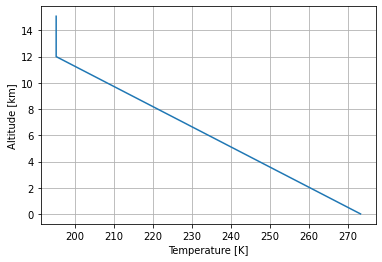

In [210]:
plt.plot(temp, meteo_alt*1e-3)
plt.grid(True)
plt.xlabel('Temperature [K]')
plt.ylabel('Altitude [km]')
plt.savefig('fig5', dpi=200)

# Molecular Scattering

Tive um problema na definição de beta, em que há a execução de np.diag() de um número.
Além disso, não sei como implementar as constantes que deveriam ser retornadas.

In [163]:
%run alphabeta.ipynb

In [164]:
lambd = 355*1e-9
co2 = 400


alpha_mol, beta_mol, LR_mol = alphabeta(pres, temp, lambd, co2)

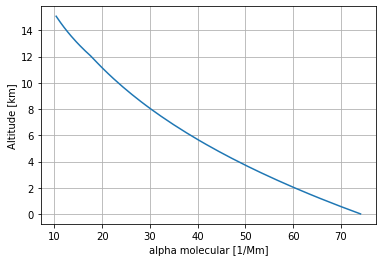

In [165]:
plt.plot(alpha_mol*1e6, meteo_alt*1e-3)
plt.grid(True)
plt.xlabel('alpha molecular [1/Mm]')
plt.ylabel('Altitude [km]')
plt.savefig('fig6', dpi=200)

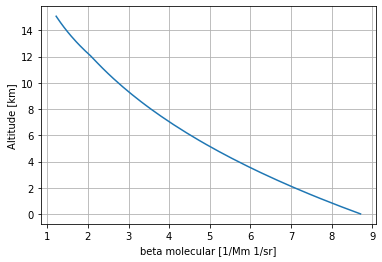

In [166]:
plt.plot(beta_mol*1e6, meteo_alt*1e-3)
plt.grid(True)
plt.xlabel('beta molecular [1/Mm 1/sr]')
plt.ylabel('Altitude [km]')
plt.savefig('fig7', dpi=200)

# built the simulated molecular signal

Como a integração te tira um grau de liberdade, fiz initial=0 para ter uma array com mesmo tamanho de beta_mol.

In [211]:
model = (beta_mol * np.exp(-2*integrate.cumtrapz(alpha_mol, meteo_alt, initial=0))) / meteo_alt**2
bg = int(1e2)
s355 = s355 + bg
s355 = pd.Series(np.random.poisson(lam=s355))

(1e-10, 1000000000000000.0)

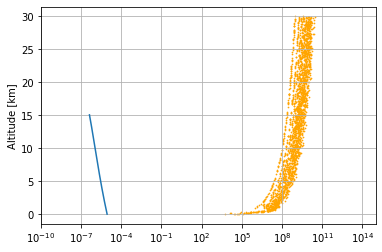

In [212]:
plt.semilogx(model*meteo_alt*meteo_alt, meteo_alt*1e-3)
plt.scatter((s355-bg)*alt*alt, alt*1e-3, s=0.5, c='orange')
plt.grid(True)
plt.ylabel('Altitude [km]')
plt.xlim(1e-10, 1e15)

**<font size="5">^^^ Não sei o que tá rolando aí em cima.</font>**

Erro se eu não mudar pra s355_bg. Acho que tem a ver com o "Negative data ignored".

Text(0, 0.5, 'Measured signal')

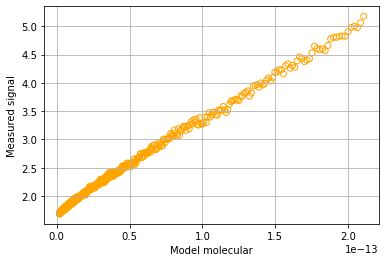

In [170]:
plt.scatter(model[270:], s355l[270:], facecolors = 'none', edgecolors = 'orange')
plt.grid(True)
plt.xlabel('Model molecular')
plt.ylabel('Measured signal')

In [171]:
f = lambda x, a, b: a*x + b

fit = optimize.curve_fit(f, model[270:], s355l[270:], p0=(1e13, 116))

a = fit[0][0]
b = fit[0][1]

fit

(array([1.63431470e+13, 1.71071067e+00]),
 array([[ 1.10460096e+21, -3.79376178e+07],
        [-3.79376178e+07,  3.64267708e-06]]))

Text(0, 0.5, 'Measured signal')

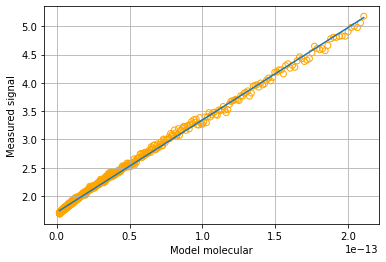

In [172]:
plt.scatter(model[270:], s355l[270:], facecolors = 'none', edgecolors = 'orange')
plt.plot(model[270:], f(model[270:], a, b))
plt.grid(True)
plt.xlabel('Model molecular')
plt.ylabel('Measured signal')

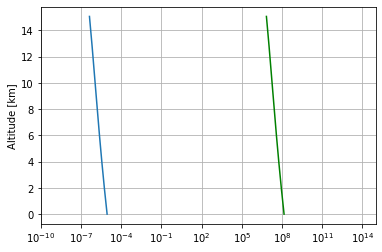

In [173]:
plt.semilogx(model*meteo_alt*meteo_alt, meteo_alt*1e-3)
plt.scatter((s355l-bg)*altl*altl, altl*1e-3, s=0.5, c='orange')
plt.semilogx(model*meteo_alt*meteo_alt*a, meteo_alt*1e-3, c='green')
plt.grid(True)
plt.ylabel('Altitude [km]')
plt.xlim(1e-10, 1e15)
plt.savefig('fig8', dpi=200)

In [174]:
alt

array([7.50000e+00, 1.50000e+01, 2.25000e+01, ..., 2.99850e+04,
       2.99925e+04, 3.00000e+04])

In [184]:
%run fernald_new1.ipynb

zref = np.array([6*1e3, 14*1e3])
LR = 28.

z = altl[..., None]
pr = s355l.values[..., None]
ref = zref[..., None]
lambd = 355*1e-9
LidarRatio = LR
Pair = pres.values[..., None]
Tair = temp.values[..., None]


beta_par, alpha_par, LR_par, model_mol, ab_fit = fernald_new1(z,pr,ref,lambd,LidarRatio,Pair,Tair)

[[ 800]
 [1867]]
[ 800  801  802 ... 1865 1866 1867]


IndexError: index 1005 is out of bounds for axis 0 with size 1005

In [190]:
reference = np.arange(800, 1868, 1)
len(model)

1005

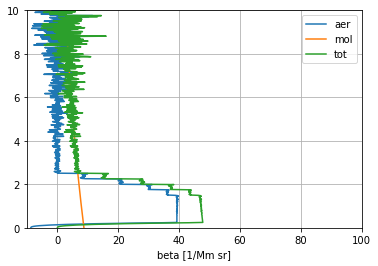

In [21]:
plt.plot((beta_par['aer'])*1e6, alt*1e-3)
plt.plot(beta_par['mol']*1e6, alt*1e-3)
plt.plot(beta_par['tot']*1e6, alt*1e-3)
plt.grid(True)
plt.legend(['aer', 'mol', 'tot'])
plt.xlim(-10, 100)
plt.ylim(0, 10)
plt.xlabel('beta [1/Mm sr]')
plt.savefig('backscatter', dpi=200)

# Testando os resultado com sobreposição

In [22]:
meteo_test = pd.read_csv('Solution355.txt', r'\s+', header=None)
meteo_test = meteo_test.rename(columns={0: 'Pressure',
                             1: 'temperature',
                             2: 'dewpoint',
                             3: 'PEC (1/m)',
                             4: 'lidar ratio (sr)',
                             5: 'depolarization ratio', 
                              6: 'altitude (m)'})

/opt/anaconda3/envs/IC/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


O arquivo Solution355.txt tem o alpha e o lidar ratio.

In [23]:
meteo_test

,Pressure,temperature,dewpoint,PEC (1/m),lidar ratio (sr),depolarization ratio,altitude (m)
0,1013.00,0.00,-9.13,1.100000e-03,28.0,0.0,7.5
1,1011.10,-0.10,-9.27,1.100000e-03,28.0,0.0,22.5
2,1009.20,-0.20,-9.36,1.100000e-03,28.0,0.0,37.5
3,1007.31,-0.29,-9.45,1.100000e-03,28.0,0.0,52.5
4,1005.42,-0.39,-9.54,1.100000e-03,28.0,0.0,67.5
...,...,...,...,...,...,...,...
1000,102.35,-77.90,-99.71,1.400000e-08,28.0,0.0,15007.5
1001,102.08,-77.90,-99.71,1.400000e-08,28.0,0.0,15022.5
1002,101.82,-77.90,-99.71,1.400000e-08,28.0,0.0,15037.5
1003,101.55,-77.90,-99.71,1.400000e-08,28.0,0.0,15052.5


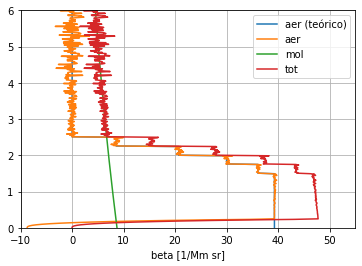

In [24]:
beta_z = meteo_test['PEC (1/m)'] / meteo_test['lidar ratio (sr)']


plt.plot(beta_z*1e6, alt*1e-3)
plt.plot((beta_par['aer'])*1e6, alt*1e-3)
plt.plot(beta_par['mol']*1e6, alt*1e-3)
plt.plot(beta_par['tot']*1e6, alt*1e-3)
plt.grid(True)
plt.legend(['aer (teórico)', 'aer', 'mol', 'tot'])
plt.xlim(-10, 55)
plt.ylim(0, 6)
plt.xlabel('beta [1/Mm sr]')
plt.savefig('final', dpi=200)

In [28]:
alfa_z

0       1.100000e-03
1       1.100000e-03
2       1.100000e-03
3       1.100000e-03
4       1.100000e-03
            ...     
1000    1.400000e-08
1001    1.400000e-08
1002    1.400000e-08
1003    1.400000e-08
1004    1.400000e-08
Name: PEC (1/m), Length: 1005, dtype: float64

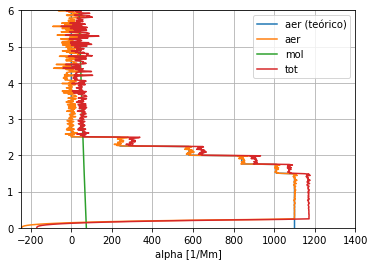

In [27]:
alfa_z = meteo_test['PEC (1/m)']

plt.plot(alfa_z*1e6, alt*1e-3)
plt.plot((alpha_par['aer'])*1e6, alt*1e-3)
plt.plot(alpha_par['mol']*1e6, alt*1e-3)
plt.plot(alpha_par['tot']*1e6, alt*1e-3)
plt.grid(True)
plt.legend(['aer (teórico)', 'aer', 'mol', 'tot'])
plt.xlim(-250, 1400)
plt.ylim(0, 6)
plt.xlabel('alpha [1/Mm]')
plt.savefig('final2', dpi=200)